In [164]:
import matplotlib.pyplot as plt
from matplotlib import animation
from JSAnimation.IPython_display import display_animation
import numpy as np
import scipy as sp
from scipy.integrate import odeint

In [249]:
time = 8*np.pi # total time in seconds
dt=0.05 # Timestep
nt = int(time / dt) # number of time steps
t0=0;
order = 3 # order of symplectic integrator
t=np.linspace(t0,nt*dt,nt) #Iniatialize time array

# define initial conditions and physical parameters
theta0= np.pi*np.array([0.62,1.2]) # initial position vector
u0 = np.pi*np.array([0,0]) # initial velocity vector
params = {"k":1.0,"L":1.0}

# position update function
def f(theta,u,t,params):
    return u

# velocity update function
def g(theta,u,t,params):
    L = params["L"]
    th1 = theta[0]; th2 = theta[1];
    s = np.cos(th1-th2); c = np.sin(th1-th2);
    denom = L*(9*np.cos(th1-th2)**2 - 16)
    
    num1 = 18*np.sin(th1) - 9*c*np.sin(th2) + 9*L*c*s*u[0]**2 + 6*L*s*u[1]**2
    num2 = -18*c*np.sin(th1) + 24*np.sin(th2) - 24*L*s*u[0]**2 - 9*L*c*s*u[1]**2
    
    return np.array([num1,num2])/denom

def animateTime(data):
    x = np.linspace(0,time,nt)
    y = data[:-1]
    line.set_data(x,y)
    gamma_text.set_text(r"$\gamma=%.3f$" % data[-1])
    return line,gamma_text

In [250]:
# Euler's method (1st order symplectic)
def euler(t,dt,theta0,u0,params):
    theta=np.zeros([2,nt])
    u=np.zeros([2,nt])
    theta[:,0]=theta0
    u[:,0]=u0
    
    for i in range(nt-1):
        u[:,i+1] = u[:,i] + dt*g(theta[:,i],u[:,i],t,params)        
        theta[:,i+1] = theta[:,i] + dt*f1(theta[:,i],u[:,i+1],t,params) # Semi-implicit Euler's method
    return [theta,u]

# Symplectic integrator
def symplectic(t,dt,theta0,u0,order,params):
    theta=np.zeros([2,nt])
    u=np.zeros([2,nt])
    theta[:,0]=theta0
    u[:,0]=u0
        
    if (order == 1):
        c = np.array([1, 0, 0, 0])
        d = np.array([1, 0, 0, 0])
    elif (order == 2):
        c = np.array([0, 1, 0, 0])
        d = np.array([0.5, 0.5, 0, 0])
    elif (order == 3):
        c = np.array([1, -2.0/3, 2.0/3, 0])
        d = np.array([-1.0/24, 3.0/4, 7.0/24, 0])
    elif(order == 4):
        x = 2 - 2**(1./3)
        c = np.array([1/(2*x), (1-2**(1./3))/(2*x), (1-2**(1./3))/(2*x), 1/(2*x)])
        d = np.array([1/x, -2**(1/3)/x, 1/x, 0])
    for i in range(nt-1):
                                        
        u[:,i+1] = u[:,i] + d[0]*dt*g(theta[:,i],u[:,i],t[i],params)
        theta[:,i+1] = theta[:,i] + c[0]*dt*f(theta[:,i],u[:,i+1],t[i+1],params)
    
        u[:,i+1] = u[:,i+1] + d[1]*dt*g(theta[:,i+1],u[:,i+1],t[i],params)
        theta[:,i+1] = theta[:,i+1] + c[1]*dt*f(theta[:,i+1],u[:,i+1],t[i+1],params)
        
        u[:,i+1] = u[:,i+1] + d[2]*dt*g(theta[:,i+1],u[:,i+1],t[i],params)
        theta[:,i+1] = theta[:,i+1] + c[2]*dt*f(theta[:,i+1],u[:,i+1],t[i+1],params)
        
        u[:,i+1] = u[:,i+1] + d[3]*dt*g(theta[:,i+1],u[:,i+1],t[i],params)
        theta[:,i+1] = theta[:,i+1] + c[3]*dt*f(theta[:,i+1],u[:,i+1],t[i+1],params)
        
    return [theta,u]

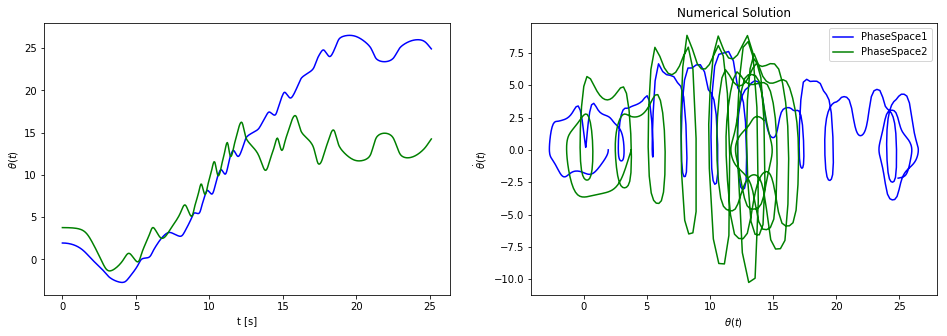

In [253]:
# Solve and plot results

theta,u = symplectic(t,dt,theta0,u0,order,params)

fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)


ax1.plot(t,theta[0,:],label="RealSpace1",color="b")
ax1.plot(t,theta[1,:],label="RealSpace2",color="g")

ax2.plot(theta[0,:],u[0,:],label="PhaseSpace1",color="b")
ax2.plot(theta[1,:],u[1,:],label="PhaseSpace2",color="g")

ax1.set_xlabel('t [s]'); ax1.set_ylabel(r'$\theta(t)$');
ax2.set_xlabel(r'$\theta(t)$'); ax2.set_ylabel(r'$\dot{\theta}(t)$');
plt.legend()
plt.title("Numerical Solution")
#plt.savefig("figures/doublePend.png")
plt.show()

In [ ]:
# Visualize pendulum trajectory
# joint location -> (x1,y1) = (L*sin(th1),-L*cos(th1))
# end location   -> (x2,y2) = (x1,y1) + 0.5*L*(sin(th2),-cos(th2))



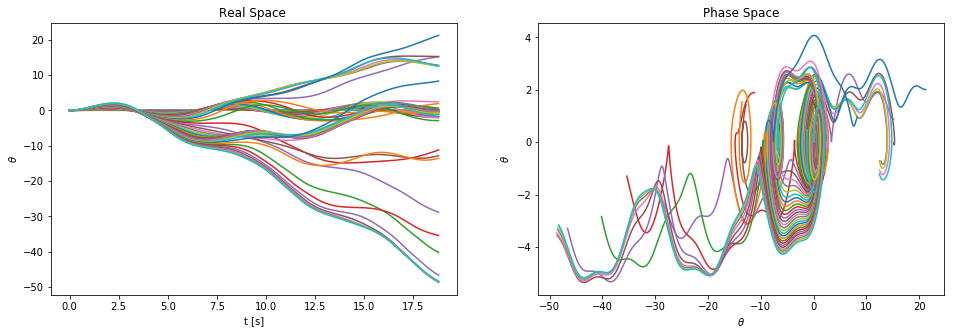


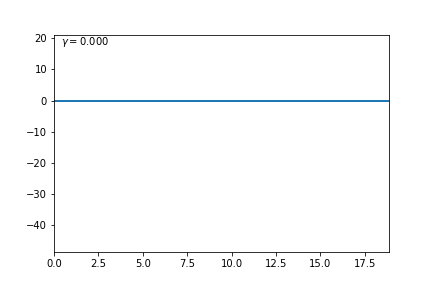
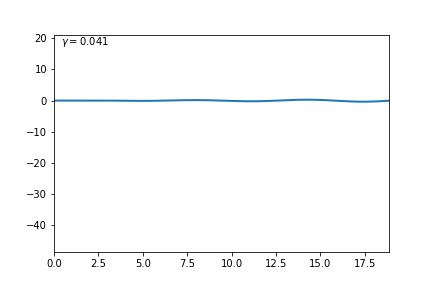
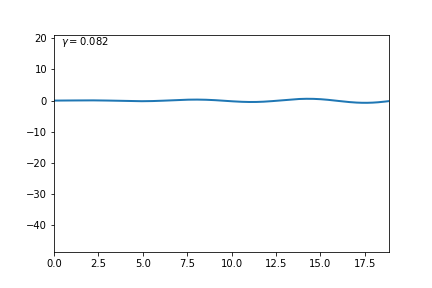
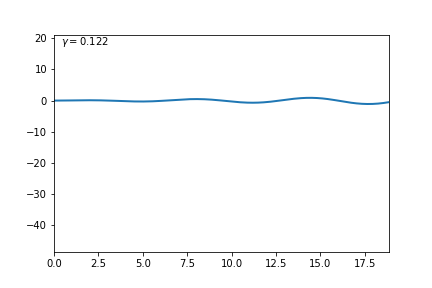
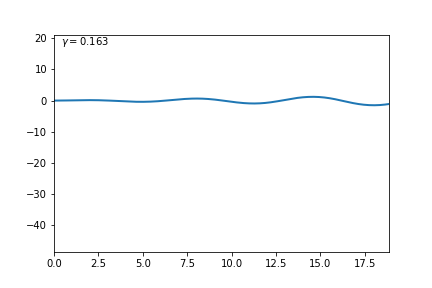
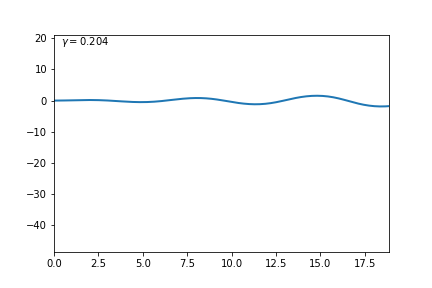
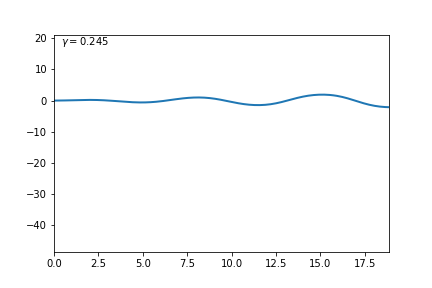
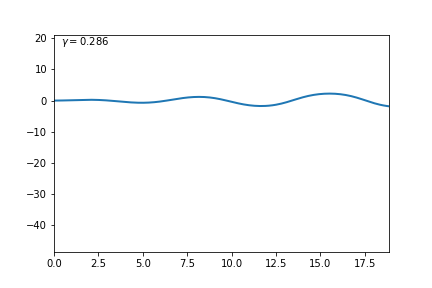
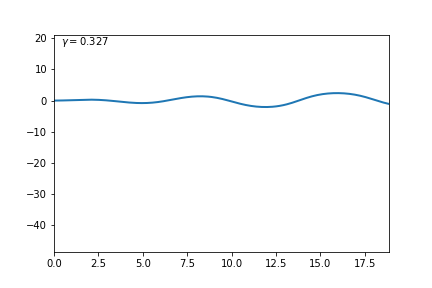
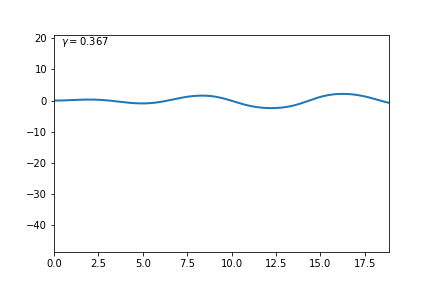
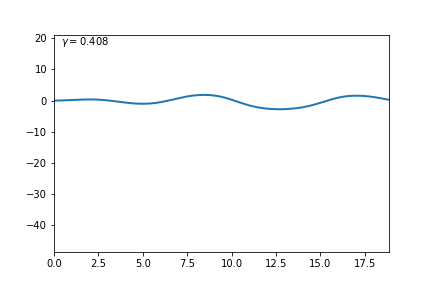
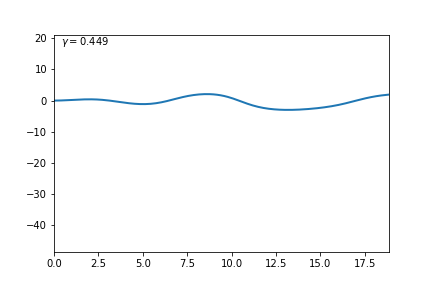
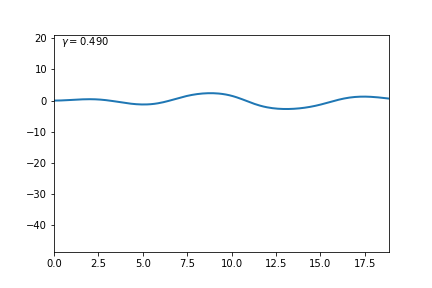
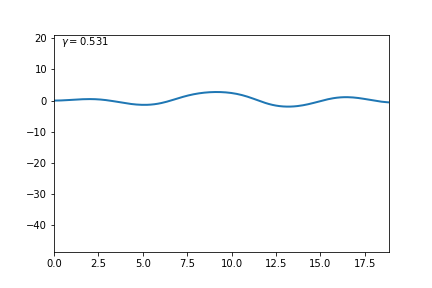
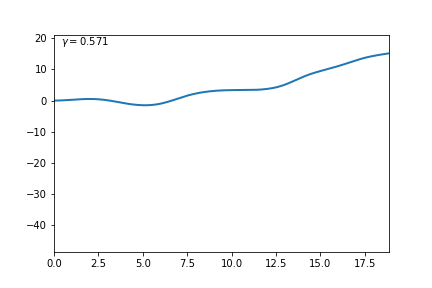
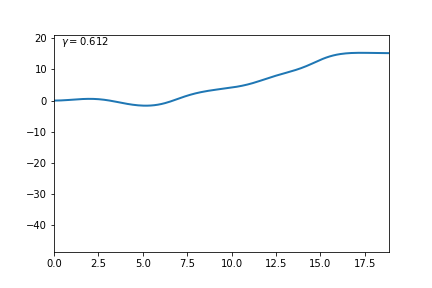
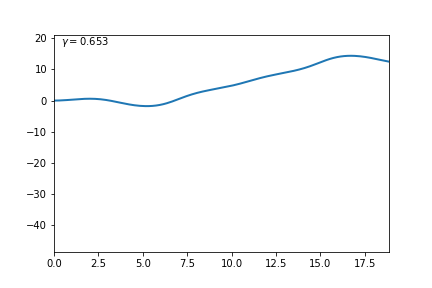
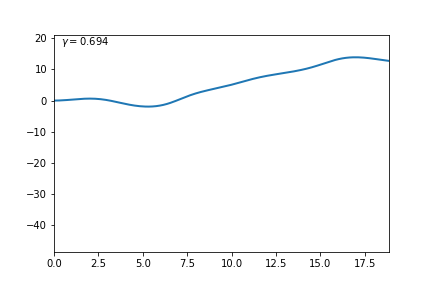
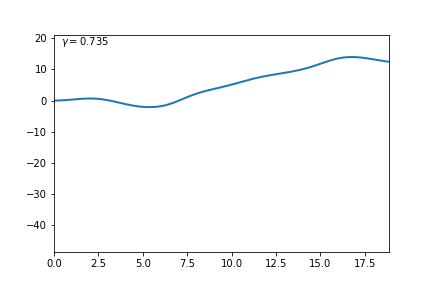
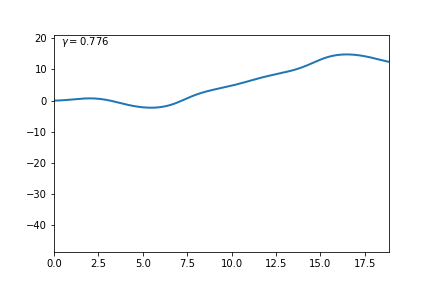
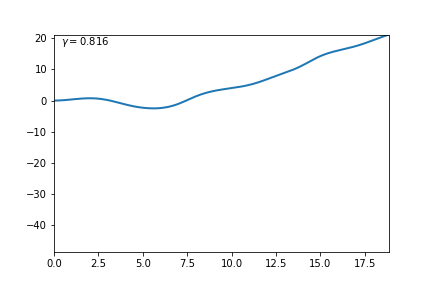
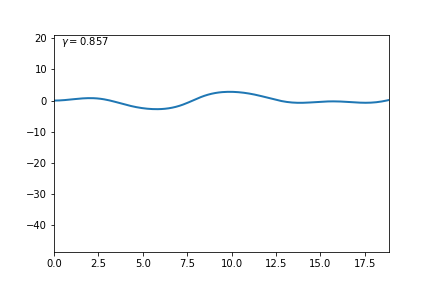
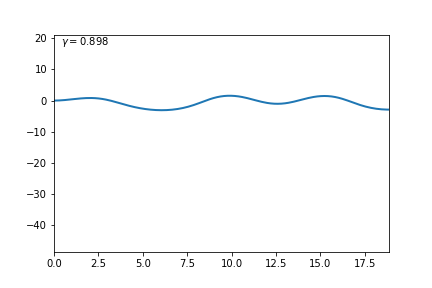
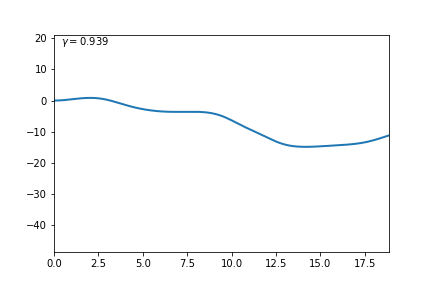
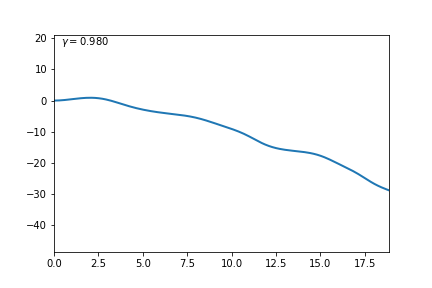
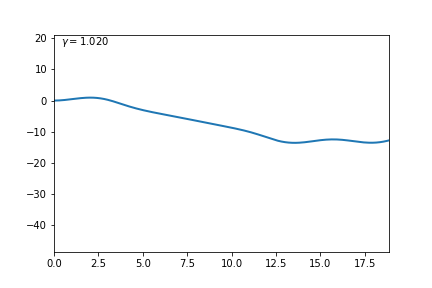
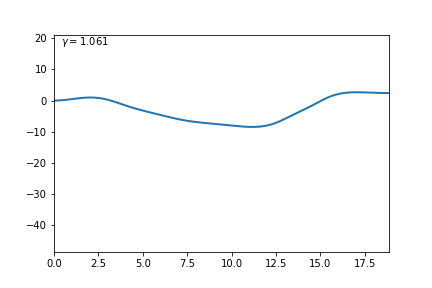
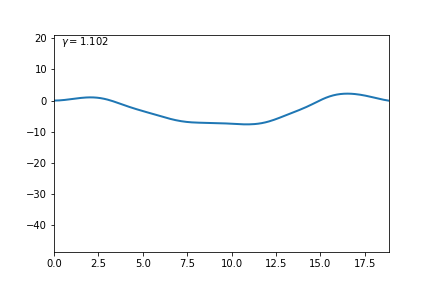
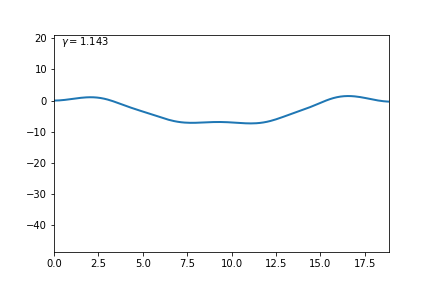
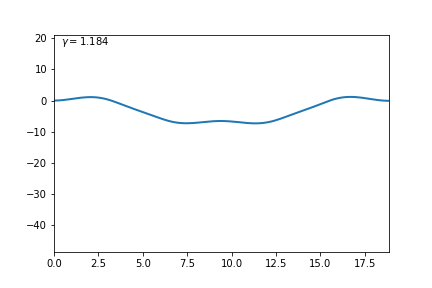
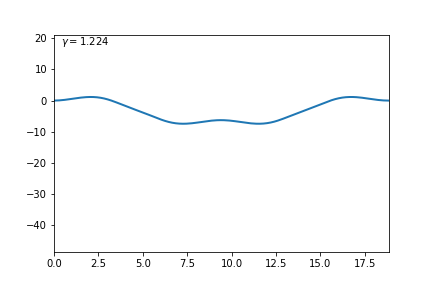
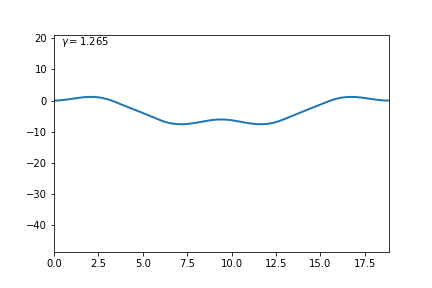
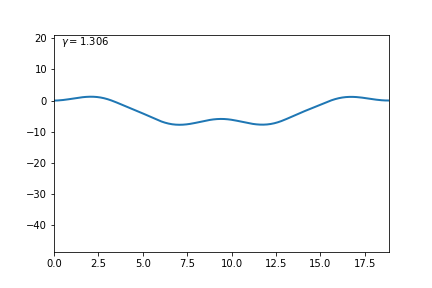
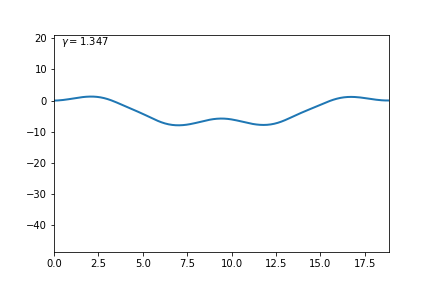
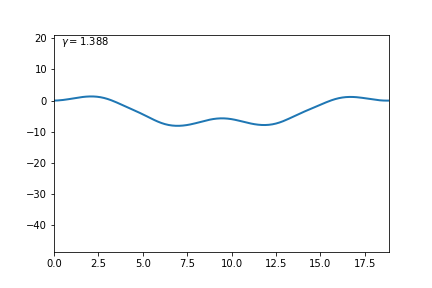
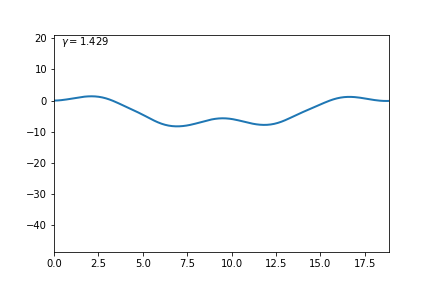
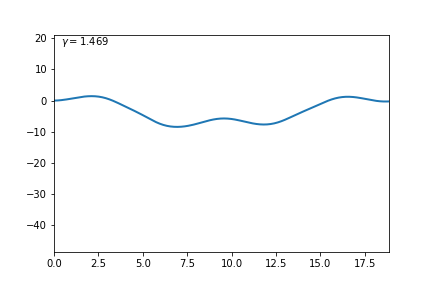
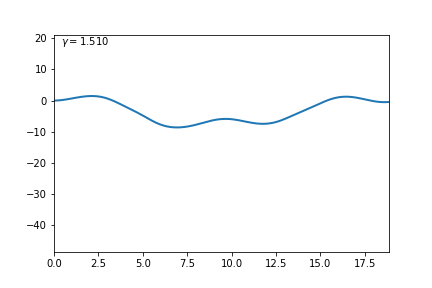
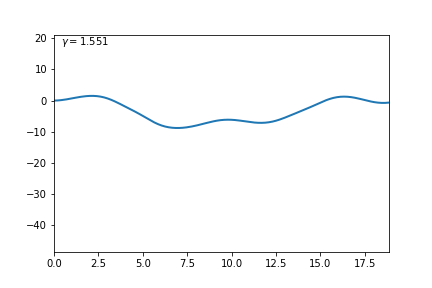
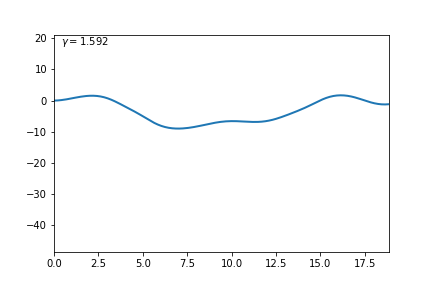
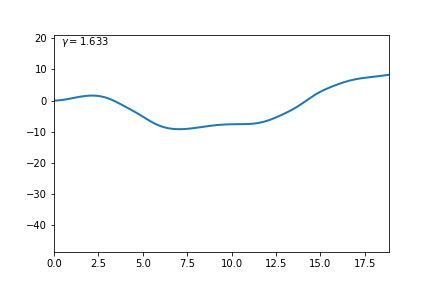
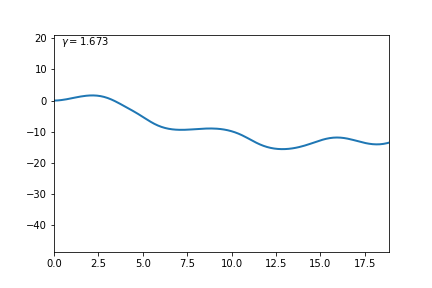
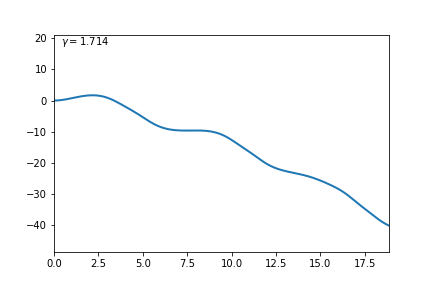
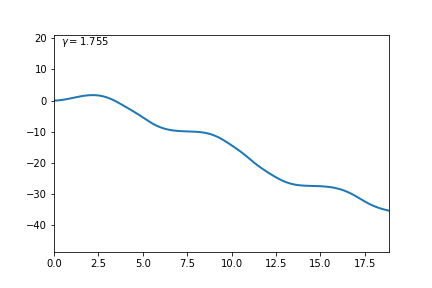
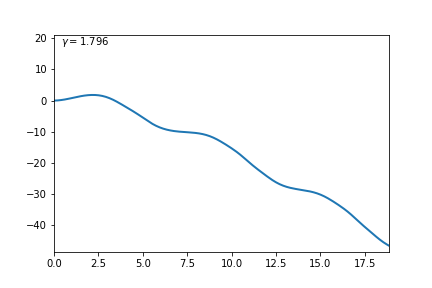
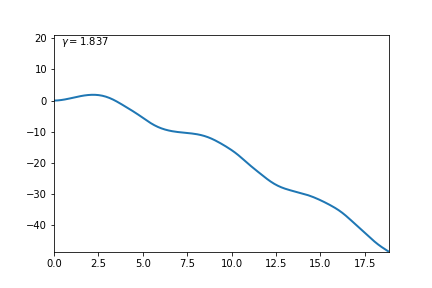
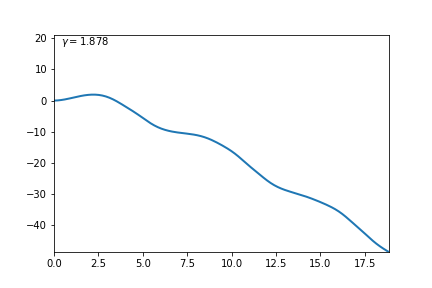
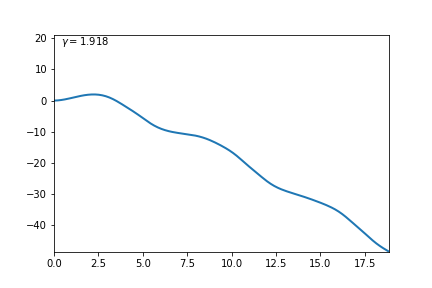
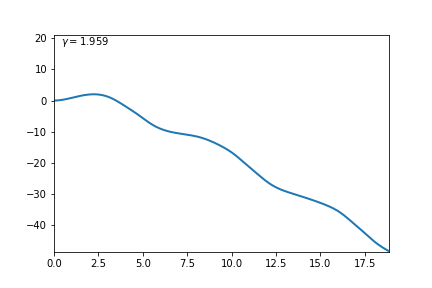
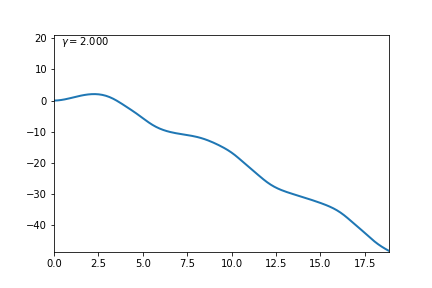

In [1454]:
# 4 - Effect of varying gamma

fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

gNum = 50 # number of gamma values
gMax = 2 # maximum gamma value
thMax = 15 # max theta to consider periodic

gammas = np.linspace(0,gMax,gNum)

# store all solutions for animation
thetaAll = np.zeros([gammas.size,nt+1])
uAll = np.zeros([gammas.size,nt+1])

# Plot results for all gammas
for i in range(gammas.size):
    params["gamma"] = gammas[i]
    theta,u = symplectic(t,dt,theta0,u0,order,params)
    ax1.plot(t,theta,label=gammas[i])
    ax2.plot(theta,u,label=gammas[i])

    thetaAll[i,:-1] = theta
    uAll[i,:-1] = u

thetaAll[:,-1] = gammas

ax1.set_title("Real Space ")
ax2.set_title("Phase Space")
ax1.set_xlabel("t [s]"); ax1.set_ylabel(r"$\theta$")
ax2.set_xlabel(r"$\theta$"); ax2.set_ylabel(r"$\dot{\theta}$")
#plt.savefig("figures/phaseSpaceDot.png")
plt.show()

# Animate

fig = plt.figure()
ax = plt.axes(xlim=(0,time),ylim=(np.min(np.min(thetaAll)),np.max(np.max(thetaAll))))
line, = ax.plot([],[],lw=2)
gamma_text = ax.text(0.02,0.95,'',transform=ax.transAxes)

animTime = animation.FuncAnimation(fig,animateTime,frames=thetaAll,interval=100)
#animPhase = animation.FuncAnimation(fig,animatePhase,frames=uAll,interval=100)

display_animation(animTime,default_mode='loop')

In [1418]:
# 5 - Identifying (theta0,gamma) pairs for which motion diverges

thMax = np.pi; thNum = 60;
gMax = 6; gNum = 60;
theta0s = np.linspace(0,thMax,thNum)
gammas = np.linspace(0,gMax,gNum)

div = np.zeros([0,3])
progress = 0

for th in theta0s:
    progress += 1
    print(int(100*progress/thNum),end="%\r") #display progress of calculations
    
    for ga in gammas:
        params["gamma"] = ga
        theta,u = symplectic(t,dt,th,u0,order,params)
        if (np.abs(theta[-1]) > np.pi):
            div = np.concatenate((div,np.array([[th,ga,theta[-1]]])))

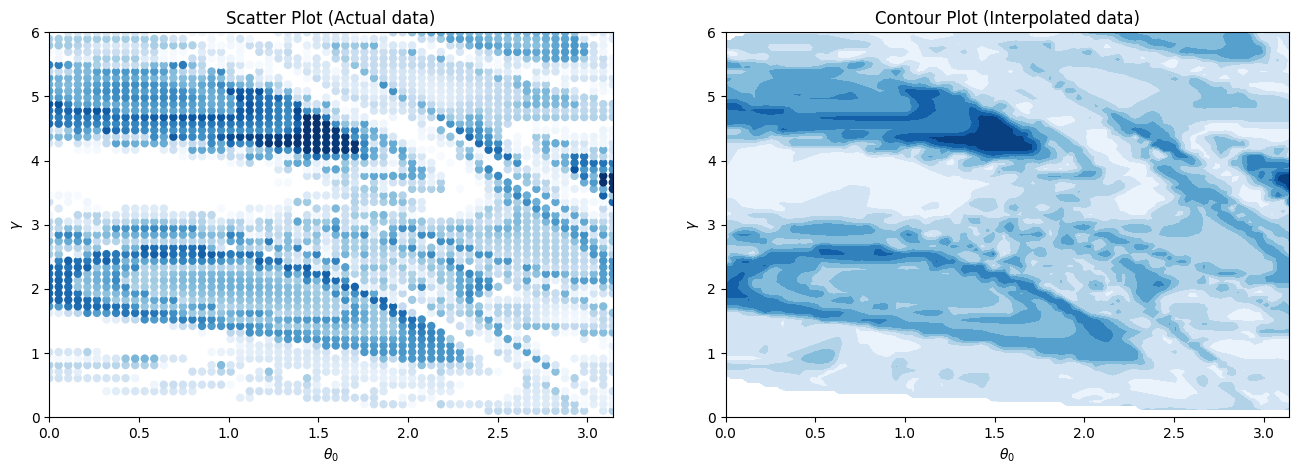

In [1211]:
# Plotting results

fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121,xlim=[0,thMax],ylim=[0,gMax])
ax2 = fig.add_subplot(122,xlim=[0,thMax],ylim=[0,gMax])
colormap = plt.cm.Blues

# Colormapped scatter plot
col = np.abs(div[:,2]) # define colors
ax1.scatter(div[:,0],div[:,1],c=col,cmap=colormap,s=25)

# Colormapped contour plot
X = np.linspace(0,thMax,100); Y = np.linspace(0,gMax,100)
Z = plt.mlab.griddata(div[:,0],div[:,1],np.abs(div[:,2]),X,Y,interp='linear')
X,Y = np.meshgrid(X,Y)
ax2.contourf(X,Y,Z,cmap=colormap)

ax1.set_title("Scatter Plot (Actual data)")
ax1.set_xlabel(r"$\theta_{0}$")
ax1.set_ylabel(r"$\gamma$")

ax2.set_title("Contour Plot (Interpolated data)")
ax2.set_xlabel(r"$\theta_{0}$")
ax2.set_ylabel(r"$\gamma$")

plt.savefig("figures/diverge2.png")

plt.show()
# Color corresponds to value of theta at final time

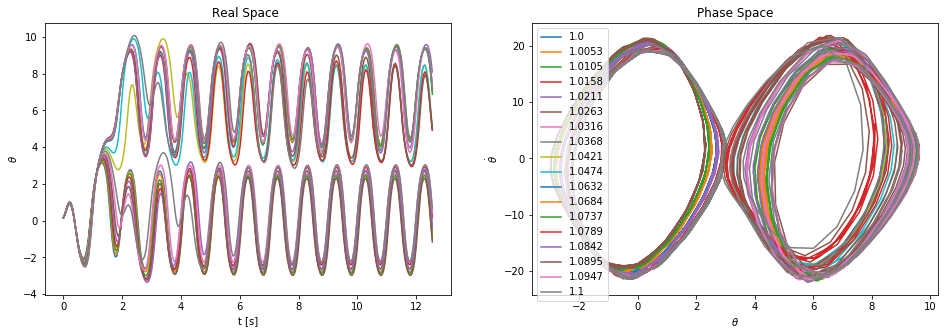

In [1410]:
# 6 - Damping, 

params = {"k":3*np.pi,"gamma":0,"w":2*np.pi,"B":0.75*np.pi}
gammas = np.linspace(0,2,20)

fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

thMax = 15

# Plot results for all gammas
for ga in gammas:
    params["gamma"] = ga
    theta,u = symplectic(t,dt,theta0,u0,order,params)
    if (np.max(np.abs(theta)) < thMax):
        ax1.plot(t,theta,label=np.around(ga,4))
        ax2.plot(theta[int(nt/2):],u[int(nt/2):],label=np.around(ga,4))

ax1.set_title("Real Space ")
ax2.set_title("Phase Space")
ax1.set_xlabel("t [s]"); ax1.set_ylabel(r"$\theta$")
ax2.set_xlabel(r"$\theta$"); ax2.set_ylabel(r"$\dot{\theta}$")
plt.legend()
plt.show()


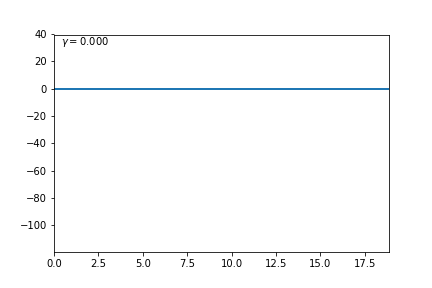
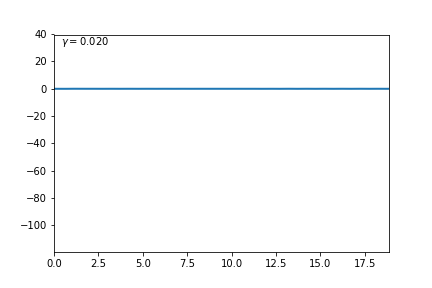
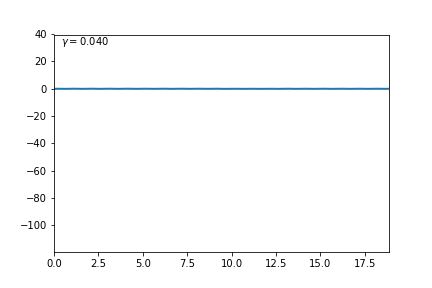
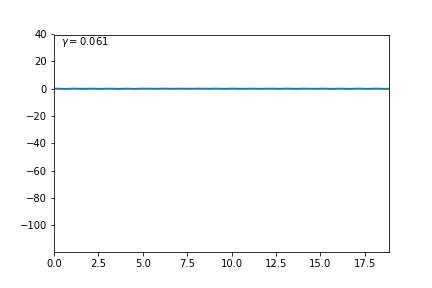
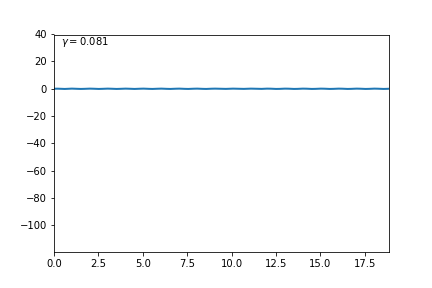
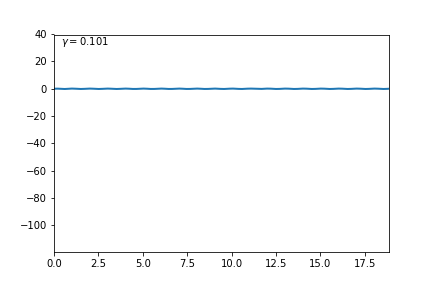
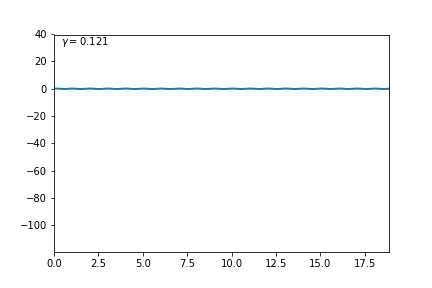
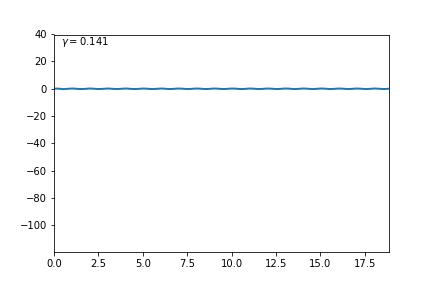
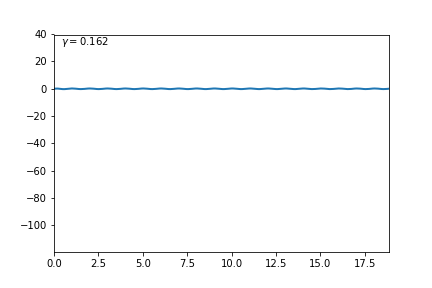
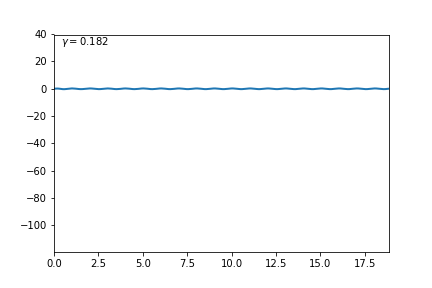
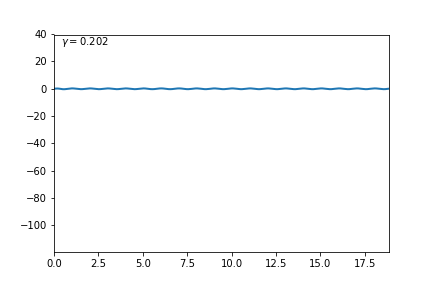
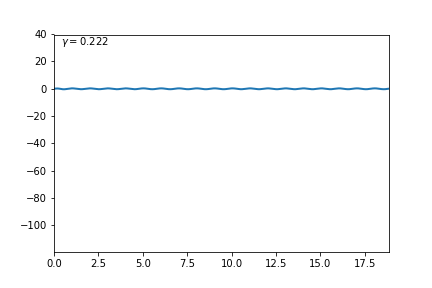
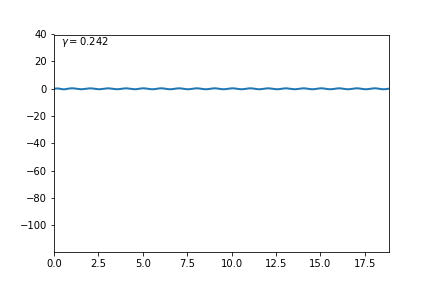
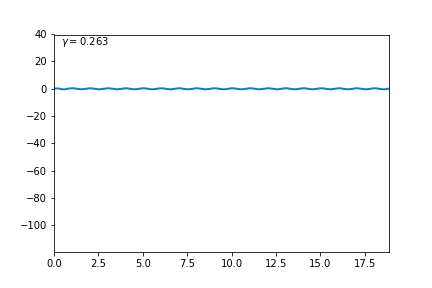
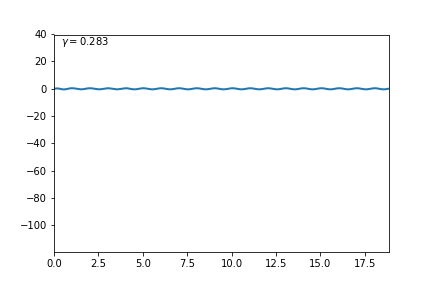
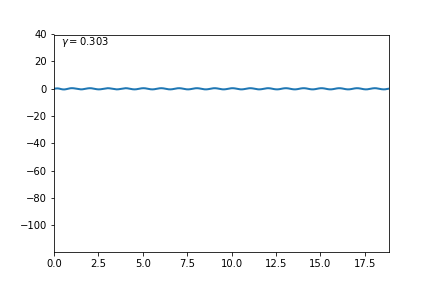
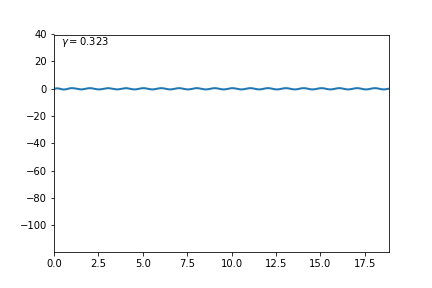
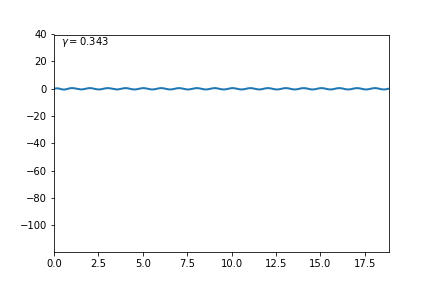
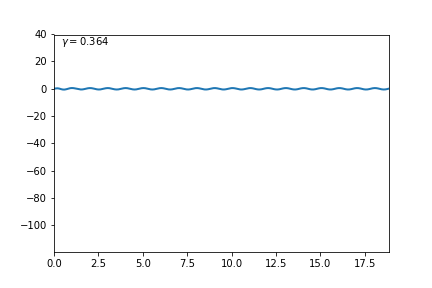
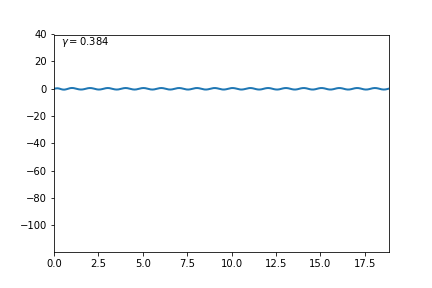
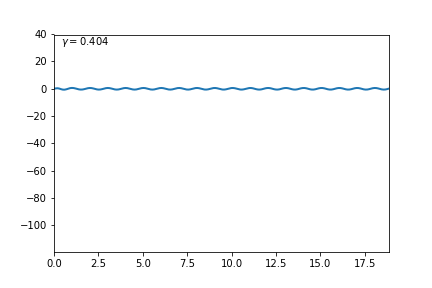
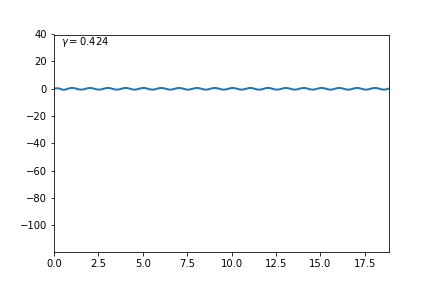
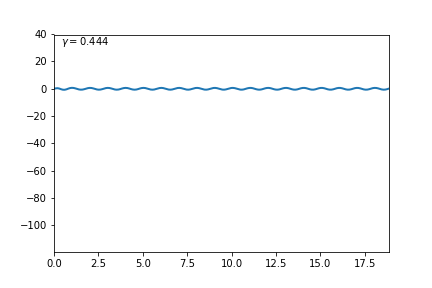
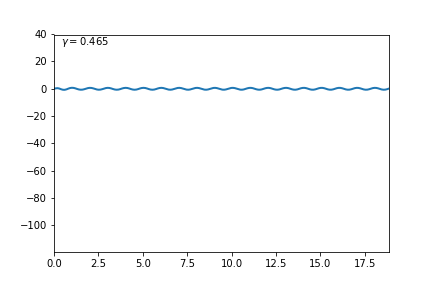
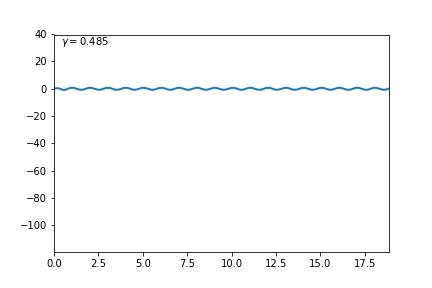
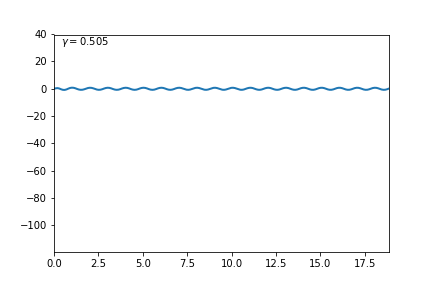
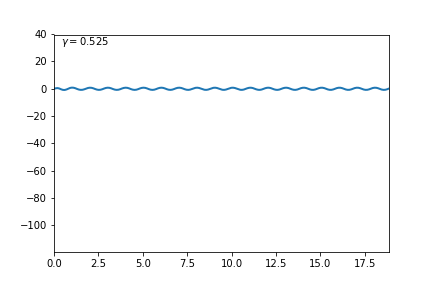
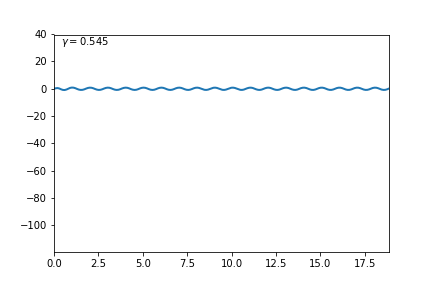
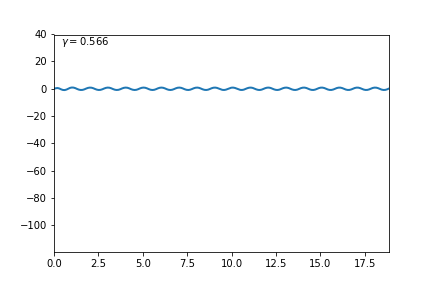
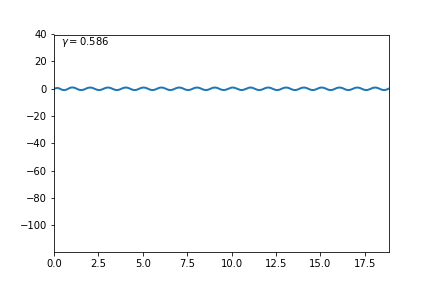
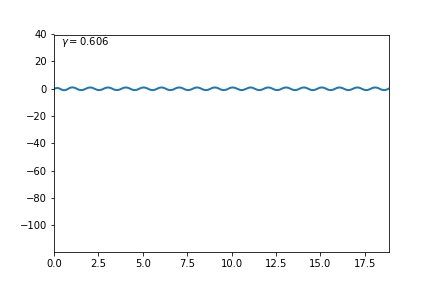
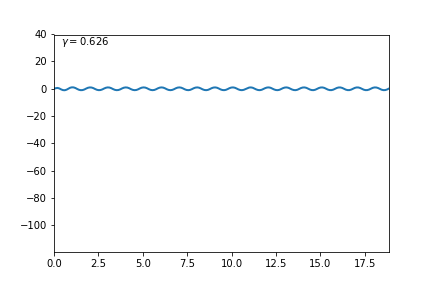
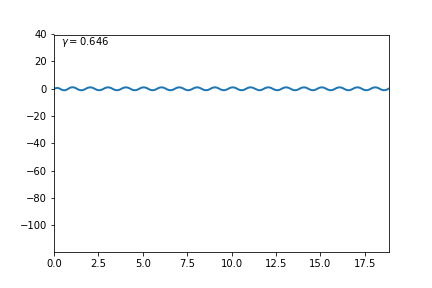
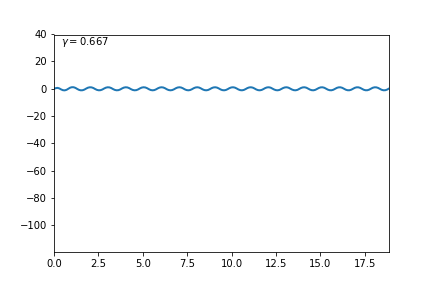
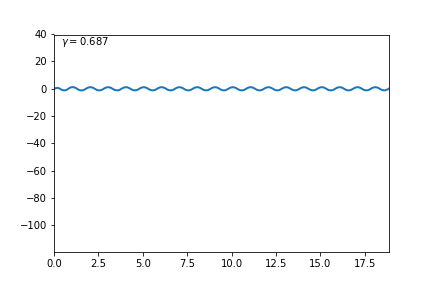
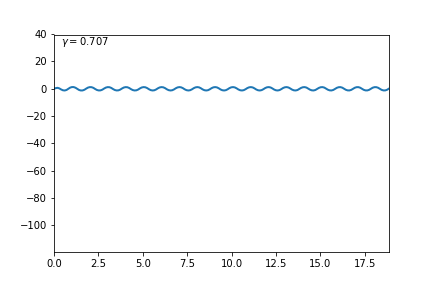
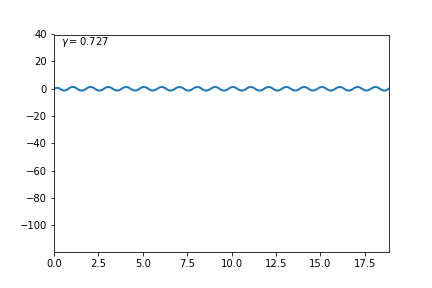
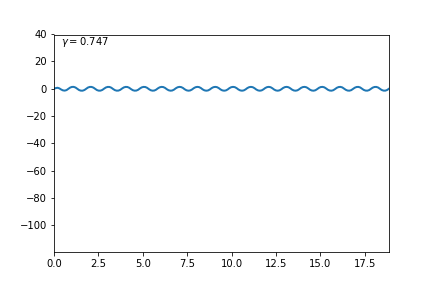
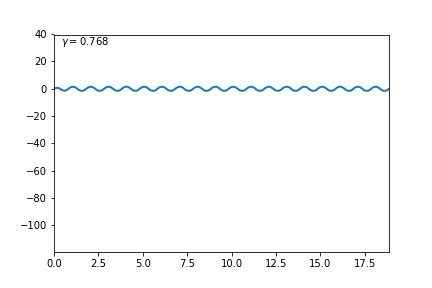
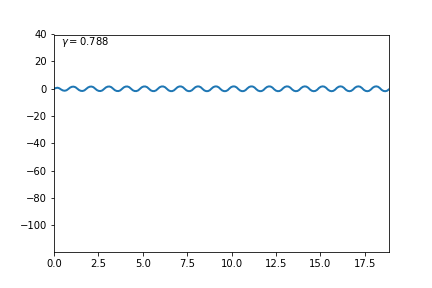
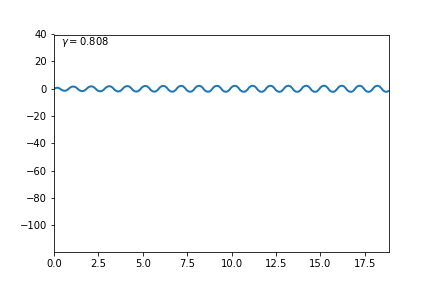
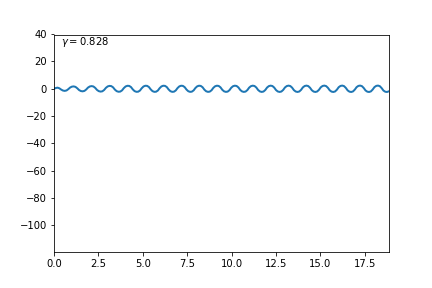
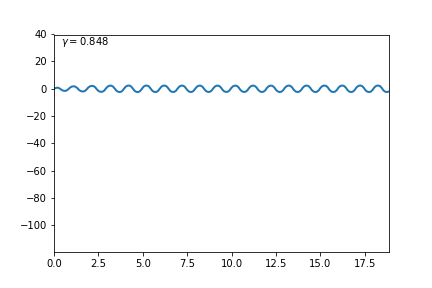
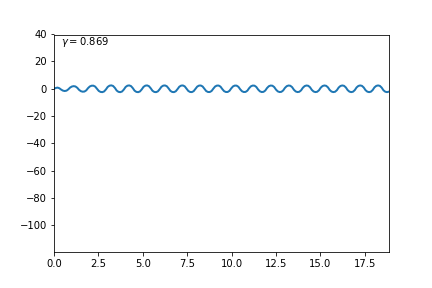
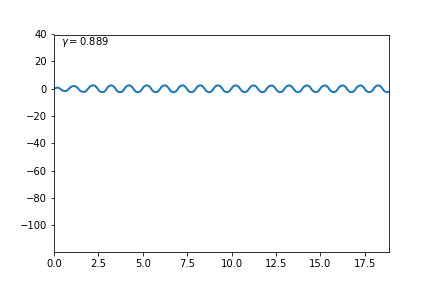
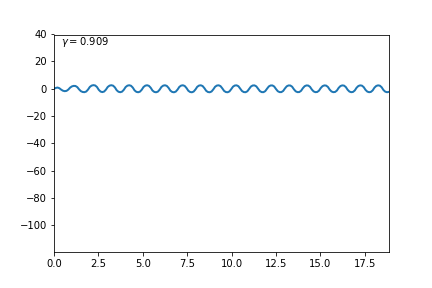
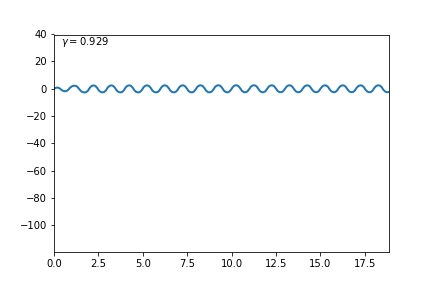
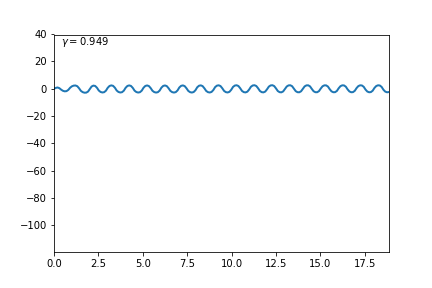
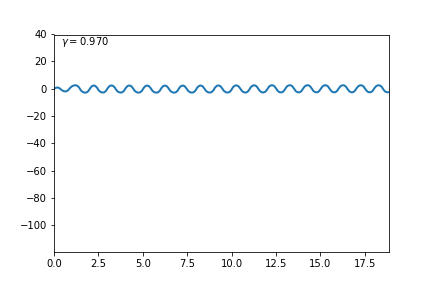
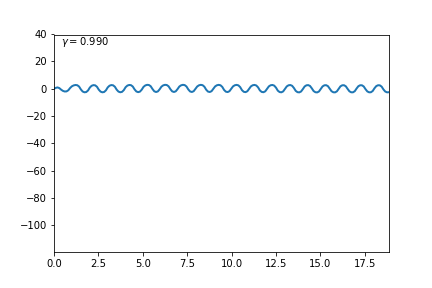
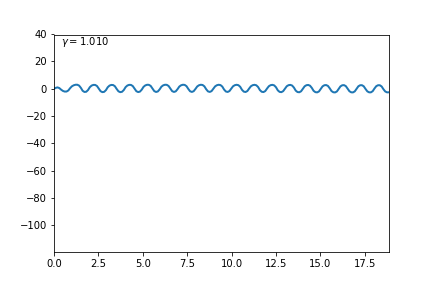
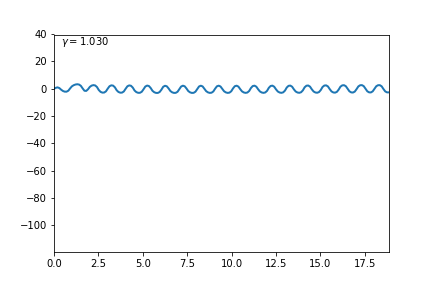
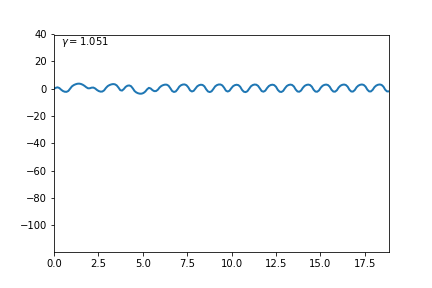
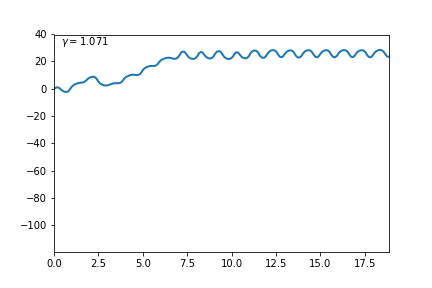
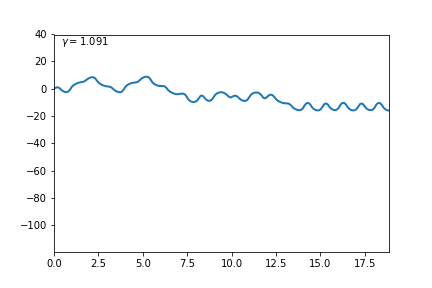
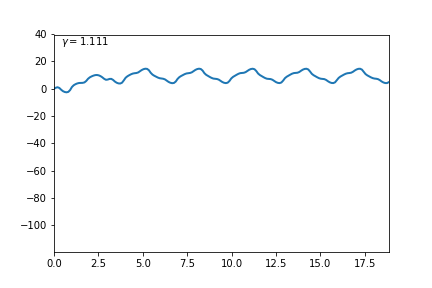
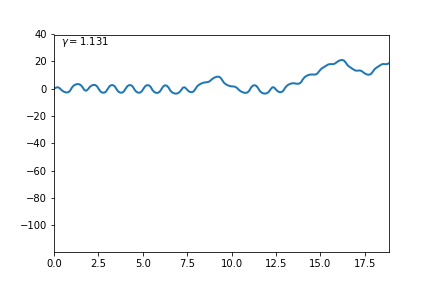
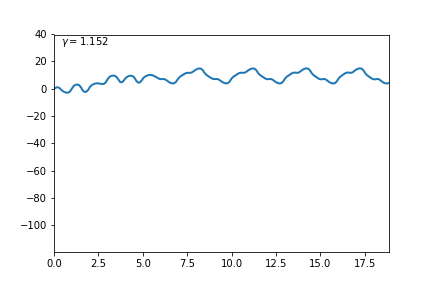
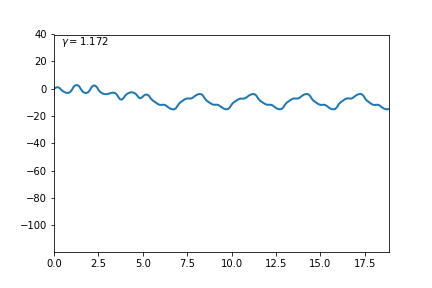
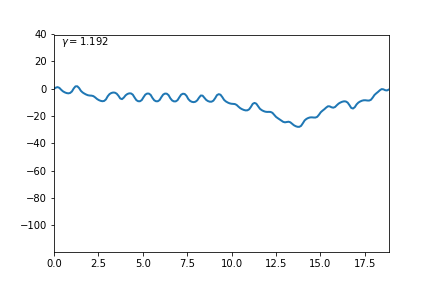
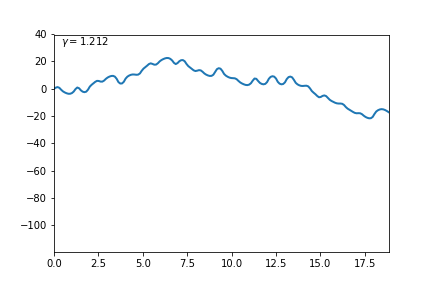
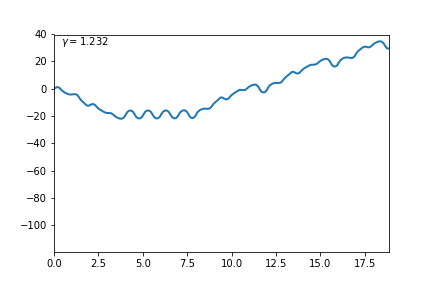
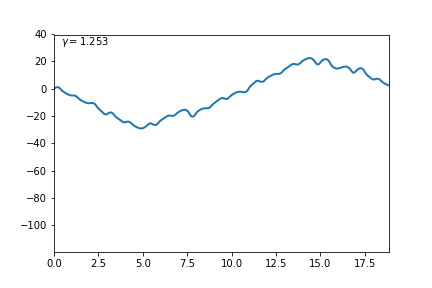
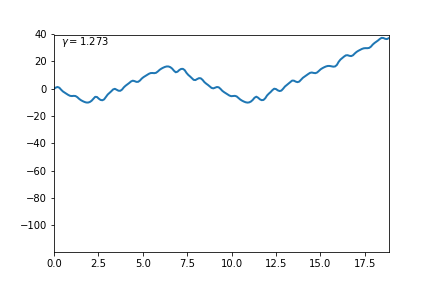
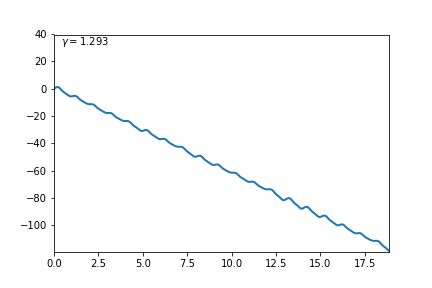
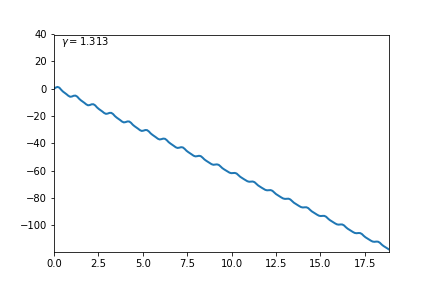
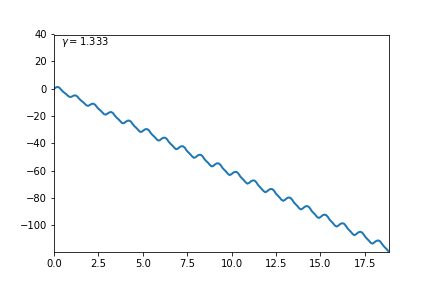
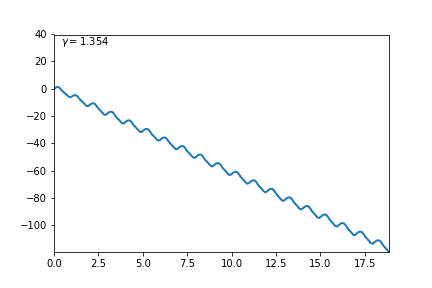
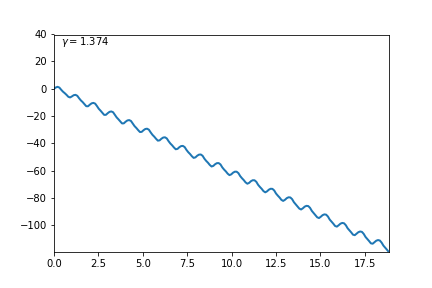
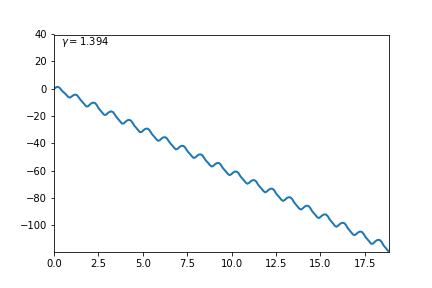
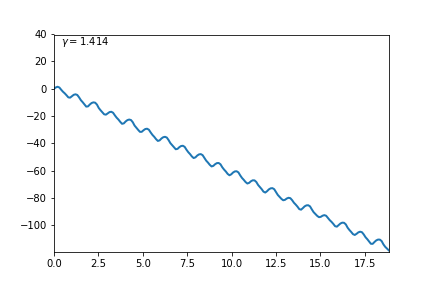
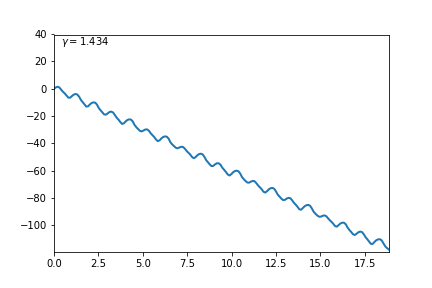
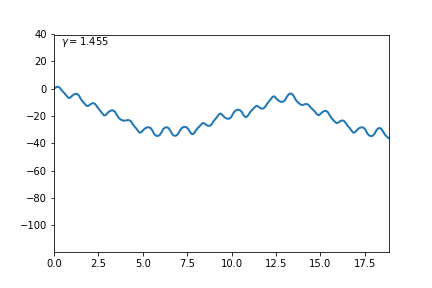
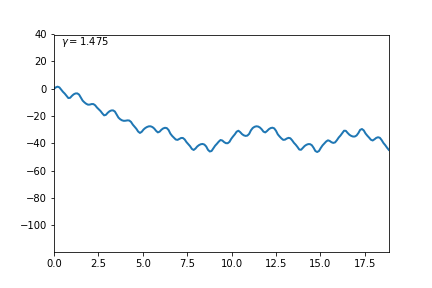
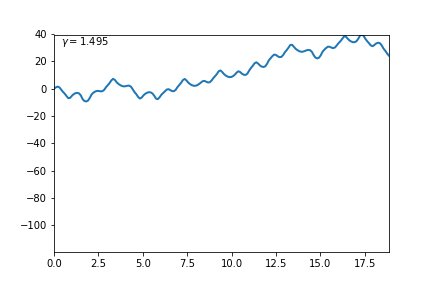
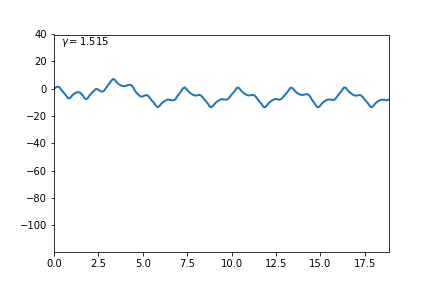
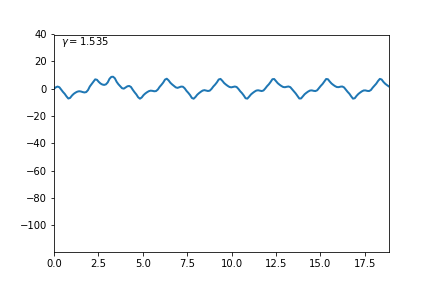
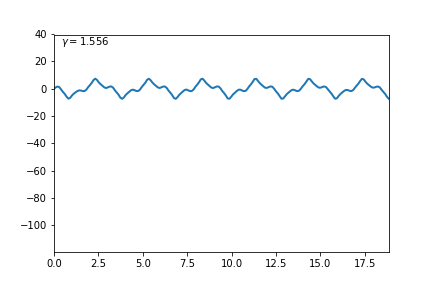
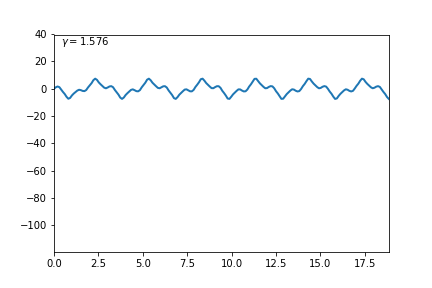
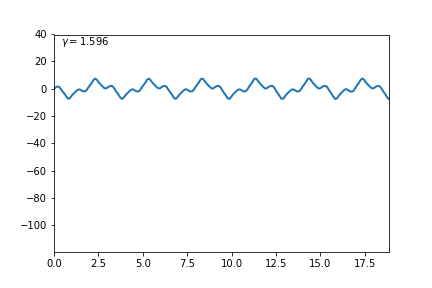
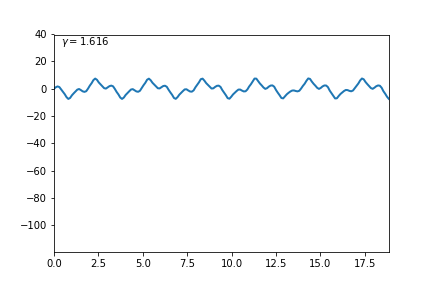
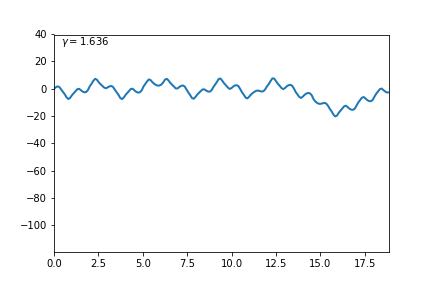
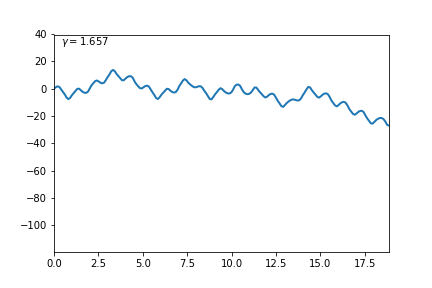
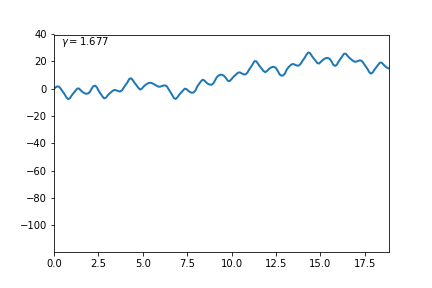
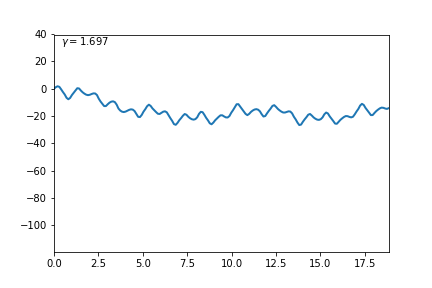
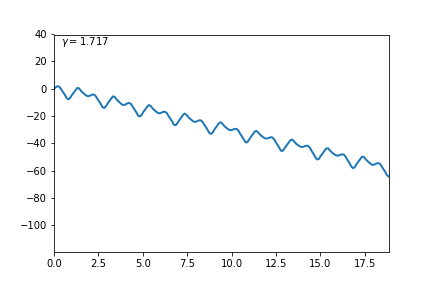
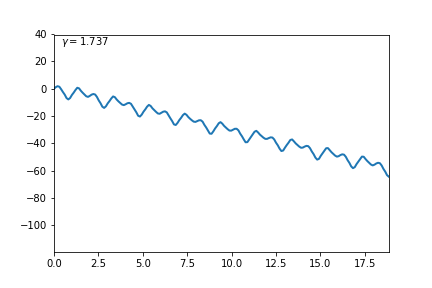
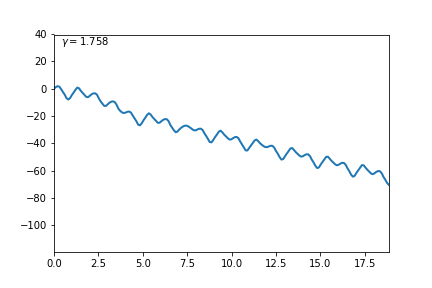
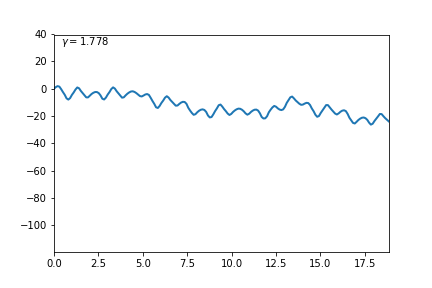
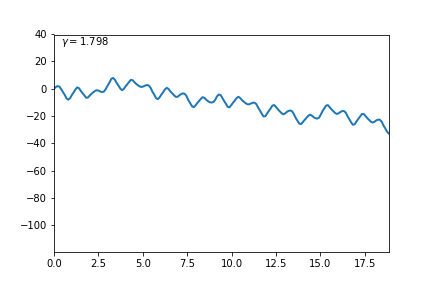
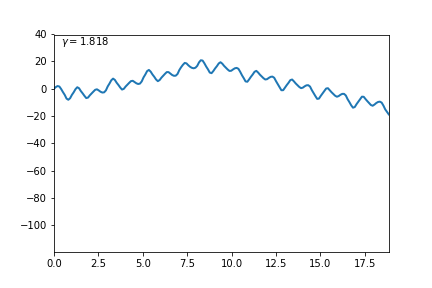
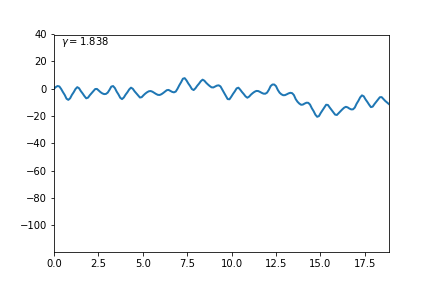
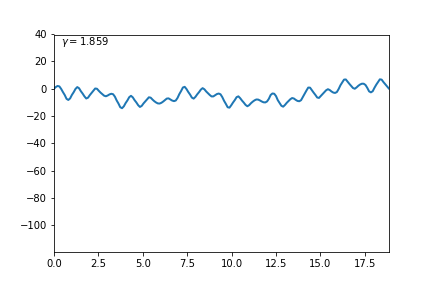
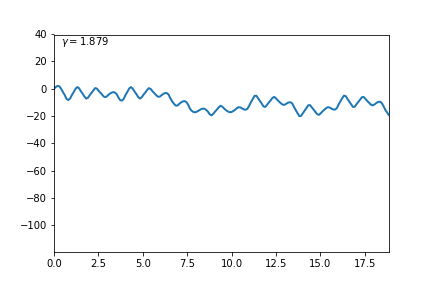
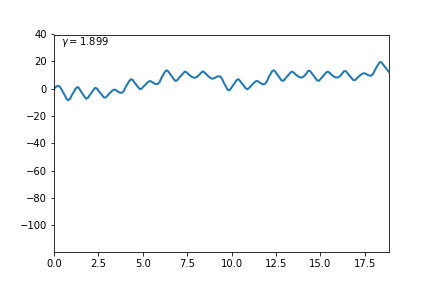
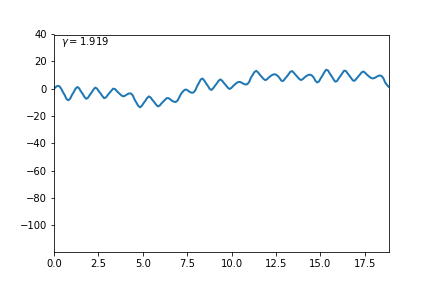
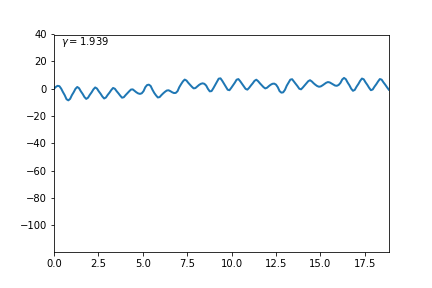
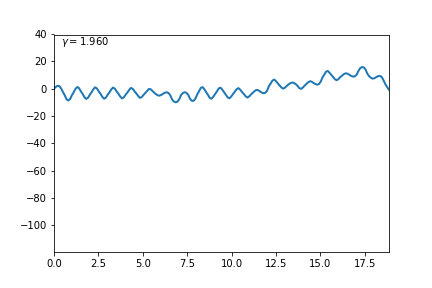
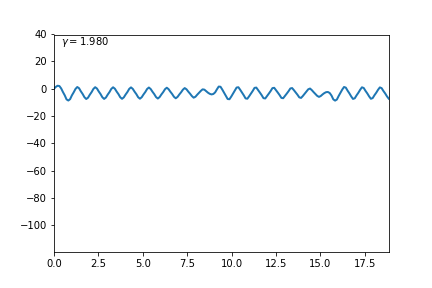
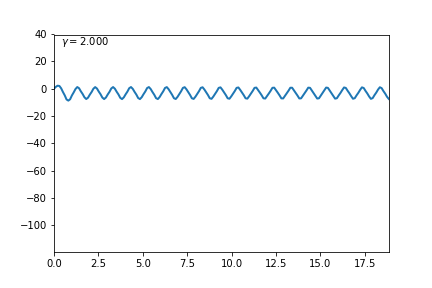

In [1456]:
# Animations (install JSAnimate with "pip3 install git+https://github.com/jakevdp/JSAnimation.git")

params = {"k":3*np.pi,"gamma":0,"w":2*np.pi,"B":0.75*np.pi}
gammas = np.linspace(0,2,100)

thetaAll = np.zeros([gammas.size,nt+1])
uAll = np.zeros([gammas.size,nt+1])

for i in range(gammas.size):
    params["gamma"] = gammas[i]
    thetaAll[i,:-1],uAll[i,:-1] = symplectic(t,dt,theta0,u0,order,params)

thetaAll[:,-1] = gammas
    
fig = plt.figure()
ax = plt.axes(xlim=(0,time),ylim=(np.min(np.min(thetaAll)),np.max(np.max(thetaAll))))
line, = ax.plot([],[],lw=2)
gamma_text = ax.text(0.02,0.95,'',transform=ax.transAxes)

animTime = animation.FuncAnimation(fig,animateTime,frames=thetaAll,interval=100)
#animPhase = animation.FuncAnimation(fig,animatePhase,frames=uAll,interval=100)

display_animation(animTime,default_mode='loop')

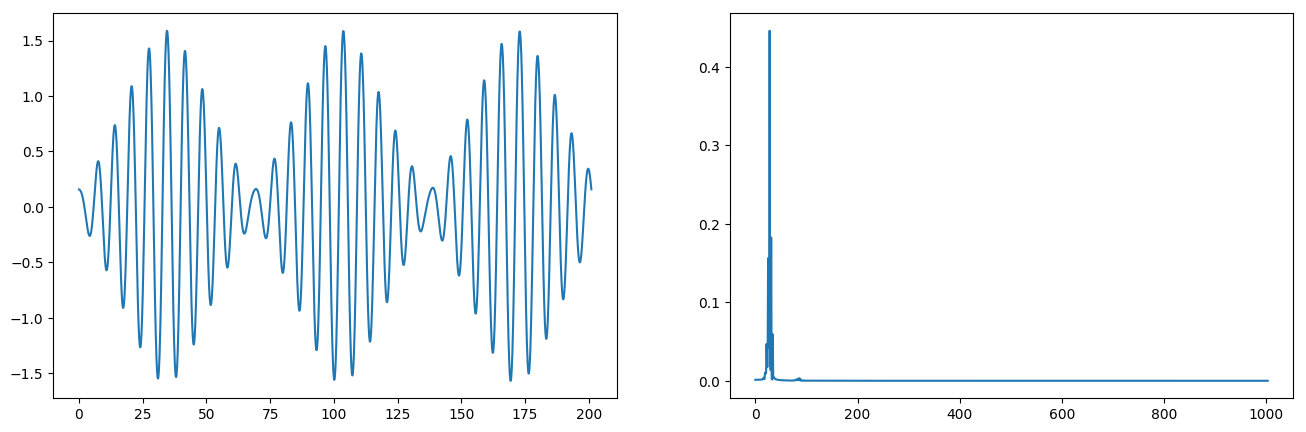

In [1278]:
# 7 - Fourier analysis

fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

theta,u = symplectic(t,dt,theta0,u0,order,params)
thetaFT = np.fft.fft(theta)/theta.size
freq = np.fft.fftfreq(nt,dt)

ax1.plot(t,theta)
ax2.plot(np.abs(thetaFT[1:int((nt+1)/2)]))
#ax1.set_axes([0,time,np.min(theta),np.max(theta)])
#ax2.set_axes([0,(nt+1)/2,0,np.max(thetaFT)])
plt.show()